In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from tensorflow.keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
train_data = pd.read_csv("Corona_NLP_train.csv", encoding='latin_1')
test_data = pd.read_csv("Corona_NLP_test.csv", encoding='latin_1')

In [3]:
train_data.shape

(41157, 6)

In [4]:
test_data.shape

(3798, 6)

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [6]:
test_data.info

<bound method DataFrame.info of       UserName  ScreenName             Location     TweetAt  \
0            1       44953                  NYC  02-03-2020   
1            2       44954          Seattle, WA  02-03-2020   
2            3       44955                  NaN  02-03-2020   
3            4       44956          Chicagoland  02-03-2020   
4            5       44957  Melbourne, Victoria  03-03-2020   
...        ...         ...                  ...         ...   
3793      3794       48746            Israel ??  16-03-2020   
3794      3795       48747       Farmington, NM  16-03-2020   
3795      3796       48748        Haverford, PA  16-03-2020   
3796      3797       48749                  NaN  16-03-2020   
3797      3798       48750  Arlington, Virginia  16-03-2020   

                                          OriginalTweet           Sentiment  
0     TRENDING: New Yorkers encounter empty supermar...  Extremely Negative  
1     When I couldn't find hand sanitizer at Fred Me...

In [7]:
train_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [8]:
test_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


<Axes: >

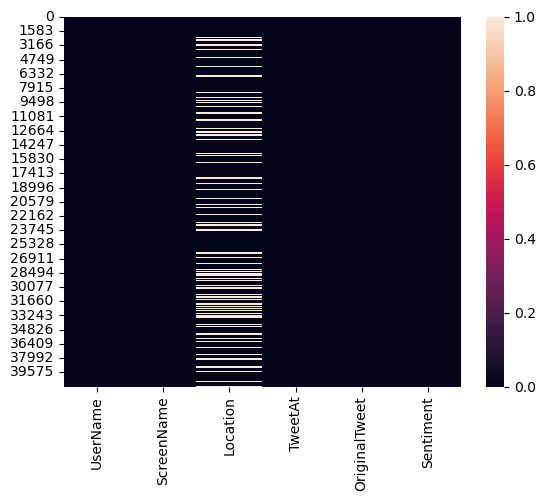

In [9]:
sns.heatmap(train_data.isnull())

<Axes: >

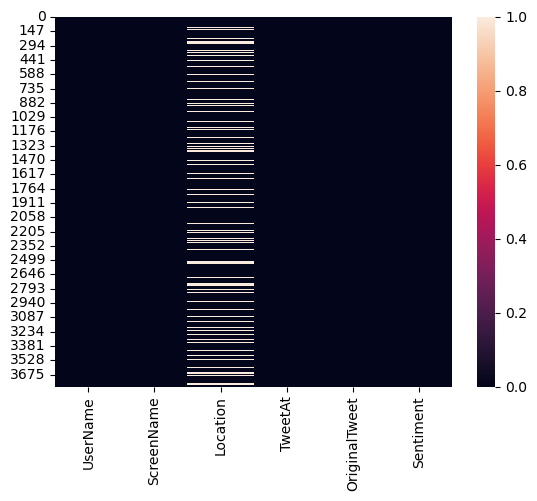

In [10]:
sns.heatmap(test_data.isnull())

In [11]:
train_data.drop_duplicates(inplace= True)
test_data.drop_duplicates(inplace=True)

In [12]:
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

In [13]:
# copying the dataset into new data
train_df = train_data.copy()
test_df = test_data.copy()

In [14]:
print(train_df.isnull().sum())
print("*"*50)
print(test_df.isnull().sum())

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64
**************************************************
UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64


<Axes: xlabel='count', ylabel='Sentiment'>

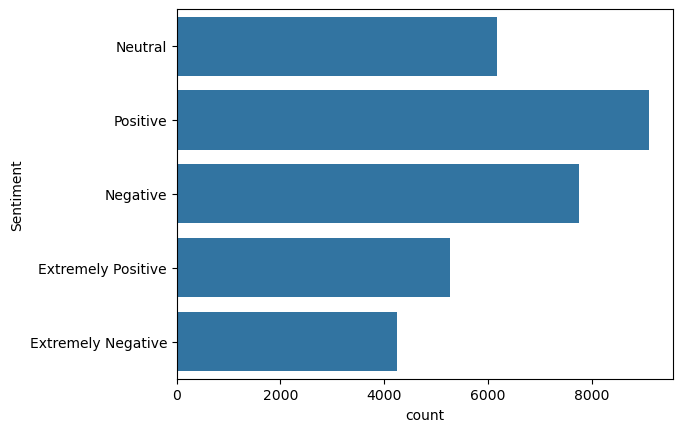

In [15]:
sns.countplot(train_df['Sentiment'])

In [16]:
def change_sen(sentiment):
    if sentiment == "Extremely Positive":
        return 'positive'
    elif sentiment == "Extremely Negative":
        return 'negative'
    elif sentiment == "Positive":
        return 'positive'
    elif sentiment == "Negative":
        return 'negative'
    else:
        return 'netural'

In [17]:
train_df['Sentiment'] = train_df['Sentiment'].apply(lambda x: change_sen(x))
test_df['Sentiment'] = test_df['Sentiment'].apply(lambda x: change_sen(x))

<Axes: xlabel='count', ylabel='Sentiment'>

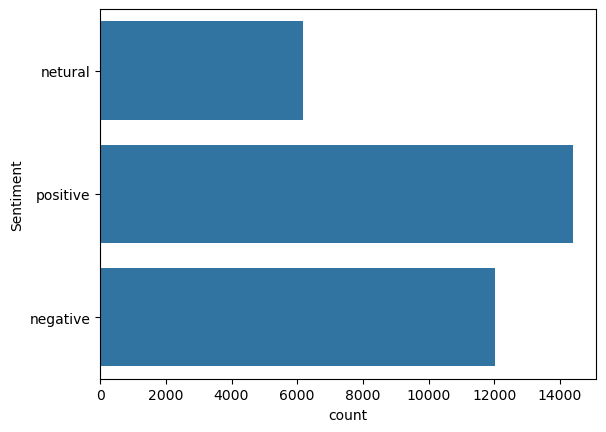

In [18]:
sns.countplot(train_df['Sentiment'])

<Axes: xlabel='count', ylabel='Sentiment'>

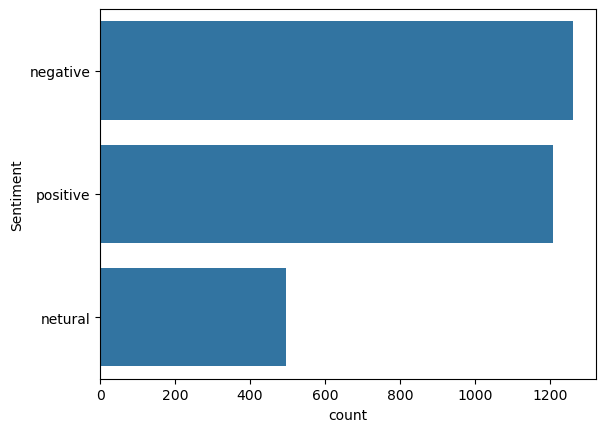

In [19]:
sns.countplot(test_df['Sentiment'])

In [20]:
# load stop words
stop_word = stopwords.words('english')

In [21]:
def clean(text):

    #     remove urls
    text = re.sub(r'http\S+', " ", text)

    #     remove mentions
    text = re.sub(r'@\w+',' ',text)

    #     remove hastags
    text = re.sub(r'#\w+', ' ', text)

    #     remove digits
    text = re.sub(r'\d+', ' ', text)

    #     remove html tags
    text = re.sub('r<.*?>',' ', text)
    
    #     remove stop words 
    text = text.split()
    text = " ".join([word for word in text if not word in stop_word])
    
      
    return text

In [22]:
train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(lambda x: clean(x))
test_df['OriginalTweet'] = test_df['OriginalTweet'].apply(lambda x: clean(x))

In [23]:
df_train = train_df.iloc[:,4:]
df_test = test_df.iloc[:,4:]

In [24]:
df_train.head()

,OriginalTweet,Sentiment
0,,netural
1,advice Talk neighbours family exchange phone n...,positive
2,Coronavirus Australia: Woolworths give elderly...,positive
5,As news regionÂs first confirmed COVID- case ...,positive
6,Cashier grocery store sharing insights To prov...,positive


In [25]:
l = {"netural":0, "positive":1,"negative":2}

In [26]:
df_train['Sentiment'] = df_train['Sentiment'].map(l)
df_test['Sentiment']  = df_test['Sentiment'].map(l)

In [27]:
x_train = df_train['OriginalTweet'].copy()
x_test = df_test['OriginalTweet'].copy()

y_train = df_train['Sentiment'].copy()
y_test = df_test['Sentiment'].copy()

In [28]:
x_train.shape, y_train.shape,x_test.shape, y_test.shape

((32567,), (32567,), (2964,), (2964,))

In [29]:
max_len = np.max(x_train.apply(lambda x :len(x)))

In [30]:
tokenizer = Tokenizer()

In [31]:
tokenizer.fit_on_texts(x_train)
vocab_length = len(tokenizer.word_index) + 1

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

x_train = pad_sequences(x_train, maxlen=max_len, padding='post')
x_test = pad_sequences(x_test, maxlen=max_len, padding='post')

In [32]:
print("Vocab length:", vocab_length)
print("Max sequence length:", max_len)

Vocab length: 31759
Max sequence length: 286


In [33]:
embedding_dim = 16

In [73]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3, activation='softmax')
])
# opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

In [75]:
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [80]:
from keras.utils import to_categorical

y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [82]:
num_epochs = 10
history = model.fit(x_train, y_train, epochs=num_epochs, 
                    validation_data=(x_test, y_test))

Epoch 1/10
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 1711s 2s/step - accuracy: 0.4383 - loss: 1.0468 - val_accuracy: 0.6400 - val_loss: 0.8357
Epoch 2/10
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 331s 325ms/step - accuracy: 0.7219 - loss: 0.6839 - val_accuracy: 0.8445 - val_loss: 0.4423
Epoch 3/10
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 338s 332ms/step - accuracy: 0.9011 - loss: 0.3126 - val_accuracy: 0.8593 - val_loss: 0.4140
Epoch 4/10
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 335s 329ms/step - accuracy: 0.9372 - loss: 0.2059 - val_accuracy: 0.8472 - val_loss: 0.4651
Epoch 5/10
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 345s 339ms/step - accuracy: 0.9558 - loss: 0.1489 - val_accuracy: 0.8347 - val_loss: 0.5470
Epoch 6/10
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 411s 404ms/step - accuracy: 0.9648 - loss: 0.1153 - val_accuracy: 0.8188 - val_loss: 0.7138
Epoch 7/10
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 711s 699ms/step - accuracy: 0.9712 - loss: 0.0920 - val_accuracy: 0.8320 - val_loss: 0.7072
Epoch 8/10
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 407s 400ms/step - accu

In [86]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [88]:
print(f"Accuracy on training data is:- {acc[-1]*100} %")
print(f"Loss {loss[-1]*100}")

print(f"Accuracy on validation data is:- {val_acc[-1]*100} %")
print(f"Loss {val_loss[-1]*100}")

Accuracy on training data is:- 98.32959771156311 %
Loss 5.265940725803375
Accuracy on validation data is:- 79.85829710960388 %
Loss 100.680673122406


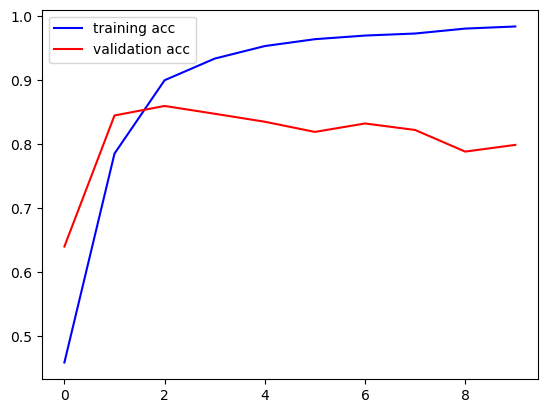

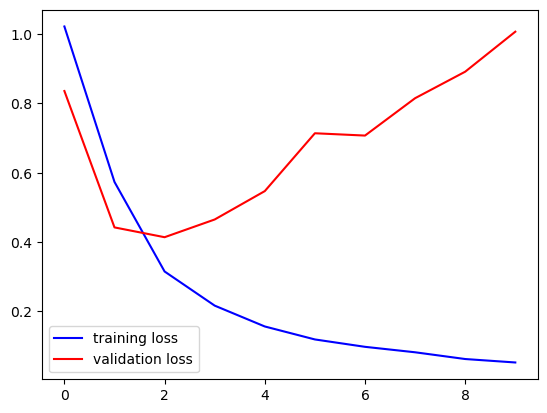

In [90]:
epochs = range(len(acc))

plt.plot(epochs, acc,'b',label='training acc')
plt.plot(epochs, val_acc, 'r', label='validation acc')
plt.legend()
plt.show()


plt.plot(epochs, loss,'b',label='training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.legend()
plt.show()